# Compute behavioral similarity (via syllable usage) across individuals for different ages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform
from toolz import partial
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, LONGTOGENY_AGE_CMAP

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-individualization", tight_layout=False)

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_females_relabeled_usage_matrix_v00.parquet')
df = df.sort_index(axis='columns')

df = df.query('age < 90')
keep_sylls = df.columns[df.median() > 0.005]
df = df[keep_sylls]

index = ['age', 'mouse', 'uuid', 'subject_name', 'session_name', 'date']

In [5]:
df.index.get_level_values('age').unique()

Index([3.4285714626312256, 3.5714285373687744, 3.7142856121063232,
        3.857142925262451,                4.0, 4.4285712242126465,
       4.5714287757873535,  4.714285850524902,  4.857142925262451,
                      5.0, 5.4285712242126465, 5.5714287757873535,
        5.714285850524902,  5.857142925262451,                6.0,
       6.4285712242126465, 6.5714287757873535,  6.714285850524902,
        6.857142925262451,                7.0, 7.4285712242126465,
       7.5714287757873535,  7.714285850524902,  7.857142925262451,
                      8.0,  8.571428298950195,                9.0,
        9.571428298950195,  9.857142448425293, 10.428571701049805,
       10.857142448425293, 11.428571701049805, 11.571428298950195,
       11.714285850524902, 11.857142448425293,               12.0,
       12.571428298950195,               13.0, 13.428571701049805,
                     14.0, 14.428571701049805, 15.142857551574707,
       15.285714149475098, 15.428571701049805, 15.571428298950

In [4]:
index = ['binned_age'] + index
ages = df.index.get_level_values('age')
n_bins = 10
lbls, bins = pd.cut(ages, n_bins, labels=False, retbins=True)

df['binned_age'] = lbls
df = df.reset_index()
binned_ages = df.groupby(['binned_age', 'mouse'], observed=True).mean(numeric_only=True)

In [5]:
bins

array([ 3.40057146,  6.22857149,  9.02857151, 11.82857153, 14.62857156,
       17.42857158, 20.22857161, 23.02857163, 25.82857165, 28.62857168,
       31.4285717 ])

In [6]:
def shuffle_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['age'] = df.groupby('mouse')['age'].sample(frac=1).to_numpy()
    return df.set_index(index)

In [7]:
shuff_dists = []
n_shuffs = 100
for i in range(n_shuffs):
    shuff_df = shuffle_mouse_age(df)
    dists = shuff_df.groupby('age').apply(partial(pdist, metric='jensenshannon'))
    avg_dist = dists.apply(lambda x: x.mean())
    avg_dist.name = i
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = 'shuffle'

In [8]:
shuff_df = shuff_dists.reset_index().melt(id_vars='shuffle', value_name='dist')

In [9]:
dists = df.set_index(index).groupby('age').apply(partial(pdist, metric='jensenshannon'))
avg_dist = dists.apply(lambda x: x.mean())
avg_dist.name = 'dist'

In [10]:
def shuffle_binned_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['binned_age'] = df.groupby('mouse')['binned_age'].sample(frac=1, replace=True).to_numpy()
    return df.set_index(['binned_age', 'mouse']) 

In [11]:
shuff_dists = []
n_shuffs = 1_000
for i in range(n_shuffs):
    shuff_df = shuffle_binned_mouse_age(binned_ages)
    dists = shuff_df.drop(columns=['age']).groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
    avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
    avg_dist.name = i
    avg_dist.index = pd.Index((bins[:-1] + bins[1:]) / 2, name='binned_age')
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = 'shuffle'
shuff_df = shuff_dists.reset_index().melt(id_vars='shuffle', value_name='dist')

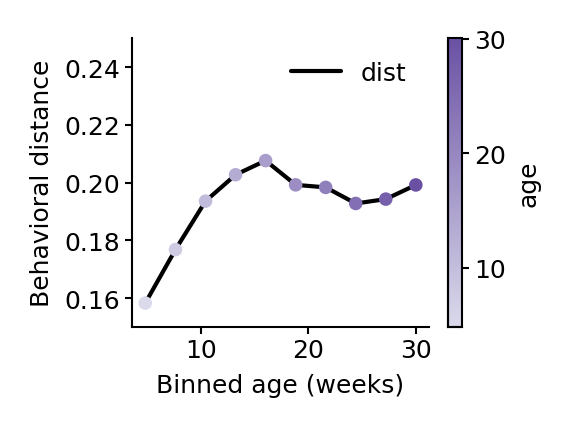

In [12]:
dists = binned_ages.drop(columns=['age']).groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
avg_dist = dists.apply(lambda x: x.mean()).reindex(range(n_bins))
avg_dist.name = 'dist'
avg_dist.index = pd.Index((bins[:-1] + bins[1:]) / 2, name='age')
avg_dist = avg_dist.dropna()

fig = figure(1.6, 1.25)
ax = fig.gca()
#sns.lineplot(data=shuff_df, x='binned_age', y='dist', errorbar=('sd', 2), color='gray', err_kws=dict(lw=0), ax=ax, label='Shuffle', zorder=0)
ax = avg_dist.plot(c='k', lw=1, zorder=1, ax=ax)
ax = pd.DataFrame(avg_dist).reset_index().plot(kind='scatter', x='age', y='dist', c='age', s=6, cmap=LONGTOGENY_AGE_CMAP, ax=ax, zorder=2)
ax.set(xlabel="Binned age (weeks)", ylabel="Behavioral distance")
ax.set_ylim(0.15,0.25)
ax.legend(frameon=False)
# legend(ax)

sns.despine()
#saver(fig, "age-vs-behavioral-distance-binned");

In [13]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'indv_distance_females_v2.pdf')